# Setup

In [26]:
import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
import os
import scvi

In [27]:
warnings.simplefilter(action='ignore', category=FutureWarning)
sns.set_context("paper")
plt.rcParams["axes.grid"] = False
sc.set_figure_params(figsize=(4,4), dpi=80, dpi_save=300, facecolor="white", frameon=False)

In [28]:
adata = sc.read("/notebook/External/Archive/Joe/processed_data/M_cell/h5ad_files/combined_WT_fezf2_KO_all_genes.h5ad")
model = scvi.model.SCVI.load("/notebook/External/Archive/Joe/processed_data/M_cell/scVI_models/combined_WT_fezf2_KO_all_genes", adata=adata)

INFO     File /notebook/External/Archive/Joe/processed_data/M_cell/scVI_models/combined_WT_fe
         zf2_KO_all_genes/model.pt already downloaded                                        


In [29]:
wtAdata = adata[adata.obs.genotype == "WT"]

# Cluster DE

In [30]:
de_df = model.differential_expression(
    adata=wtAdata,
    groupby="cell_type",
)

INFO     Received view of anndata, making copy.                                              
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
DE...: 100%|██████████| 11/11 [01:11<00:00,  6.50s/it]


In [31]:
markers = {}
cats = adata.obs.cell_type.cat.categories
for i, c in enumerate(cats):
    cid = "{} vs Rest".format(c)
    cell_type_df = de_df.loc[de_df.comparison == cid]
    cell_type_df = cell_type_df[cell_type_df.lfc_mean > 0]
    cell_type_df = cell_type_df[cell_type_df["bayes_factor"] > 3]
    cell_type_df = cell_type_df[cell_type_df["non_zeros_proportion1"] > 0.1]
    markers[c] = cell_type_df

In [36]:
for key,de_genes in markers.items():
    de_genes.to_csv(f"/notebook/Joe/M-cells/analysis/DE_Fezf2_WT_cell_types/{key}.csv")

# Plotting

In [32]:
geneList = markers["Aire+ mTECs"].head(25).index
vmin = []
vmax = []
for gene in geneList:
    vmin.append(np.quantile(adata[:, gene].layers["counts"].todense().tolist(), 0.01))
    vmax.append(np.quantile(adata[:, gene].layers["counts"].todense().tolist(), 0.99))

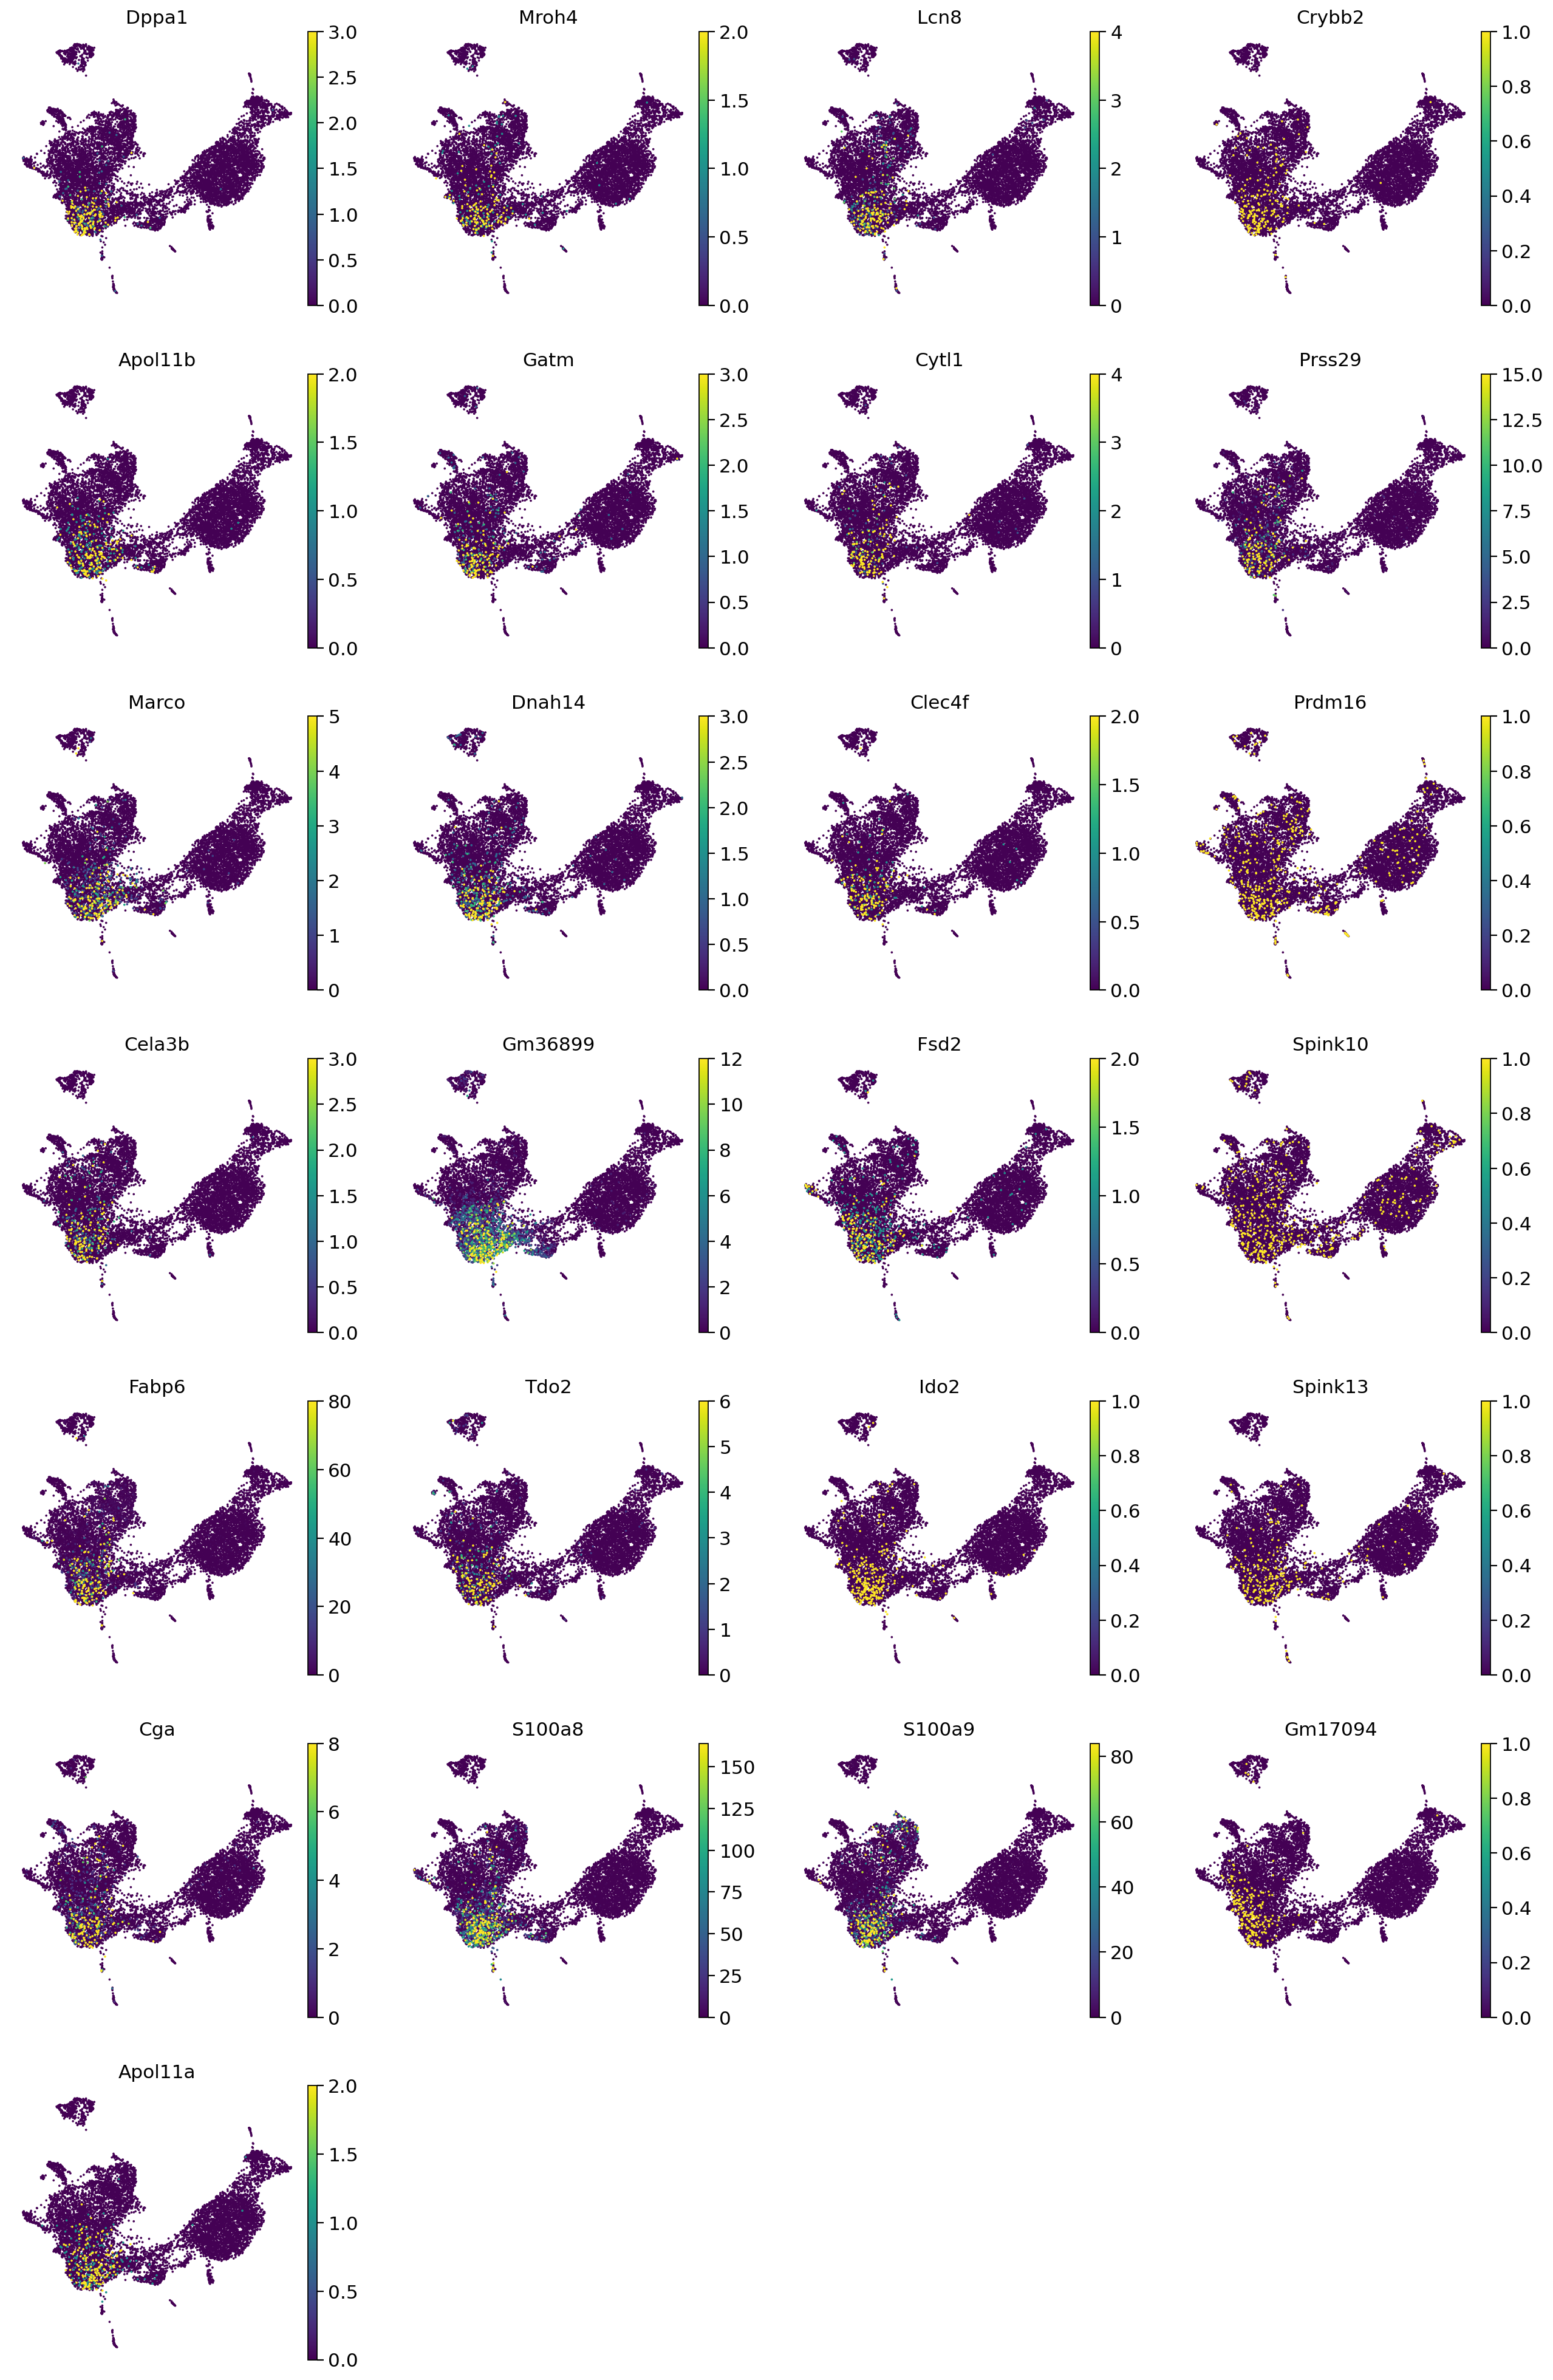

In [33]:
sc.pl.umap(
    adata,
    color=geneList,
    layer="counts",
    vmin=vmin,
    vmax=vmax,
)